## 1. Collect Basic Data

### Retrieve CryptoCurrency Market Data ###

In [37]:
import pandas as pd
import yfinance as yf
from functools import reduce
import requests
import time
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


CRYPTO = False

# Crypto Details
cryptoProducts = ["ETH-USD", "USDT-USD", "BTC-USD"]
availableGranularities = dict(zip(["1M", "5M", "15M", "1H", "6H", "1D"], [60, 300, 900, 3600, 21600, 86400]))

# Stock Details
dowTickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "NVDA"]  
sse50Tickers = ["600519.SS", "601318.SS", "601857.SS", "600036.SS", "600016.SS", "600000.SS"]  
sensexTickers = ["RELIANCE.BO", "TCS.BO", "INFY.BO", "ICICIBANK.BO", "SBIN.BO", "HINDUNILVR.BO"] 
ftse100Tickers = ["HSBA.L", "BP.L", "GSK.L", "SHEL.L", "BATS.L", "ULVR.L"]  
period = "1D"
indexProducts = dowTickers + sse50Tickers + sensexTickers + ftse100Tickers
productIds = indexProducts

if CRYPTO:
    productIds = cryptoProducts
    period = "6H"
    granularity = availableGranularities[period]
    API_THRESHOLD = 300 #Can only get 300 periods at a time from API
    PERIODS_WANTED = 2500

# not a chance
def retrieveCryptoData(productID, granularity, daysBack, endTime):
    API_URL = f"https://api.exchange.coinbase.com/products/{productID}/candles"
    daysBackDaysAgo = timedelta(days=daysBack)
    startTime = datetime.fromisoformat(endTime) - (granularity/86400) * daysBackDaysAgo

    # Convert to isoformat
    startTime = startTime.isoformat()

    # Set Request Parameters
    parameters = {
        "start" : startTime,
        "end" : endTime,
        "granularity" : str(granularity)
    }

    # Actually get data
    data = requests.get(API_URL, params = parameters, headers = {"content-type":"application/json"})
    df = pd.DataFrame(data.json(), columns=["time", "low", "high", "open", "close", "volume"])
    return df


def retrieveIndexData(ticker):
    # Define date range
    startDate = "2009-01-01"
    endDate = "2020-08-05"

    ohlcData = {}
    try:
        stockData = yf.download(ticker, start=startDate, end=endDate)
        ohlcData[ticker] = stockData[["Low", "High", "Open", "Close", "Volume"]]
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

    dfOhlc = pd.concat(ohlcData, axis=1)
    return dfOhlc


dataframes = dict()
RETRIEVE_DATA = False

if RETRIEVE_DATA:
    for productId in productIds:
        if CRYPTO:
            # Fetch PERIODS_WANTED periods of data
            end = (datetime.now()).isoformat()
            for batch in range(PERIODS_WANTED // API_THRESHOLD  + 1):
                amountToFetch = PERIODS_WANTED % API_THRESHOLD if batch == PERIODS_WANTED // API_THRESHOLD else API_THRESHOLD
                tempDF = retrieveCryptoData(productId, granularity, amountToFetch, end)
                timeInSeconds = (tempDF['time'].values)[-1]
                dt = datetime.fromtimestamp(timeInSeconds - granularity)
                end = dt.isoformat() + 'Z'
                value = dataframes.get(productId)
                if productId not in dataframes:
                    dataframes[productId] = tempDF[::-1]
                else:
                    dataframes[productId] = pd.concat([tempDF[::-1], dataframes[productId]])
        else:
            dataframe = retrieveIndexData(ticker=productId)
            columnNames = [value[1].lower() for value in list(dataframe.columns.values)]
            dataframe.columns = columnNames
            dataframes[productId] = dataframe
   
# Required for index data that pull stock data from different exchanges
def commonaliseData(data):
    commonDates = reduce(lambda x, y: x.intersection(y), [df.index for df in data.values()])
    for ticker, df in data.items():
        data[ticker] = df.reindex(commonDates)
        data[ticker]["Times"] = commonDates
    data = {ticker: df.dropna() for ticker, df in data.items()}
    PERIODS_WANTED = data.get(indexProducts[0]).shape[0]
    return data

if not CRYPTO and RETRIEVE_DATA:
    dataframes = commonaliseData(dataframes)

In [38]:
TEST_CORRECT_ORDER = False

if TEST_CORRECT_ORDER:
    testTime = dataframes[productIds[0]]['time'].values
    testTime -= testTime[0]
    plt.figure(figsize=(10, 6))
    plt.plot(testTime, color="blue")
    plt.title(f"Test Correct Order")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()

## 2. Augment State Space (add indicators)

### Indicator 1: Exponential Moving Average ###

In [39]:
import matplotlib.pyplot as plt

def EMA(array, N):
    """
    EMA_t = (Price_t * α) + (EMA_(t-1) * (1 - α))
    where:
    EMA_t = Exponential Moving Average at time t
    Price_t = Price at time t
    α (alpha) = Smoothing factor, calculated as 2 / (N + 1)
    N = Number of periods
    """
    smoothingParameter = 2/(N + 1)
    finalArray = [array[0]]
    for i in range(1, len(array)):
        finalArray.append(array[i] * smoothingParameter + finalArray[i-1] * (1 - smoothingParameter))
    return np.array(finalArray)

# expMA = EMA(closingPrices, t)
# plt.figure(figsize=(10, 6))
# plt.plot(expMA, label=f"Exponential Moving Average: T={t}", color="red")
# plt.plot(closingPrices, label="Actual Closing Prices", color="blue")
# plt.title(f"Price Data")
# plt.xlabel("Time")
# plt.ylabel("Price")
# plt.legend()
# plt.show()

### Indicator 2: Momemtum

In [40]:
def Momentum(array):
    # Percentage Change in Price/Time
    momentumArray = [(array[i] - array[i-1]) /array[i-1] for i in range(1, len(array))]
    momentumArray.insert(0, np.nan)
    return np.array(momentumArray)

# momentum = Momentum(closingPrices)
# plt.figure(figsize=(10, 6))
# plt.plot(momentum*100, color="green")
# plt.title(f"Momentum Data (as %)")
# plt.xlabel("Time")
# plt.ylabel("Momentum")
# plt.legend()
# plt.show()

### Indicator 3: Average True Range

In [41]:

def trueRange(high, low, close):
    # TR = Max[(H - L), |H - C|, |L - C|
    closing = np.insert(close, 0, np.nan, axis=0)[:len(close)]
    return np.maximum(high - low, np.abs(high - closing), np.abs(low - closing))

def averageTrueRange(high, low, close, n=14):
    trueRanges = trueRange(high, low, close)
    atr = np.empty_like(trueRanges)
    atr[:n] = np.nan  # First n values are NaN
    atr[n-1] = np.mean(trueRanges[:n])  # Initial ATR value (simple average of the first n TRs)
    for i in range(n+1, len(trueRanges)):
        atr[i] = (atr[i-1] * (n - 1) + trueRanges[i]) / n
    return atr

# aTRIndicator = averageTrueRange(highs, lows, closingPrices)
# plt.figure(figsize=(10, 6))
# plt.plot(aTRIndicator, color="Brown")
# plt.title(f"Average True Range over Time")
# plt.xlabel("Time")
# plt.ylabel("Average True Range")
# plt.legend()
# plt.show()

### Indicator 4: Commodity Channel Index

In [42]:
def commodityChannelIndex(high, low, close, n=20):
    # (Typical Price - 20_Day Moving Average) / .015 x Mean Deviation
    typicalPrices = (high + low + close) / 3
    
    movingAverage = np.full_like(high, np.nan)
    meanDeviation = np.full_like(high, np.nan)
    
    for i in range(n, len(typicalPrices)):
        movingAverage[i] = np.mean(typicalPrices[i-n:i])
        meanDeviation[i] = np.mean(np.abs(typicalPrices[i-n:i] - movingAverage[i]))
    
    cci = np.full_like(high, np.nan, dtype=np.float64)

    numerator = typicalPrices[n:] - movingAverage[n:]
    denominator = 0.015 * meanDeviation[n:]
    result = np.empty_like(numerator)

    np.divide(numerator, denominator, out=result, where=(denominator != 0))
    # a little hacky...
    result[denominator == 0] = 0

    cci[n:] = result
    return cci

# # CCI = commodityChannelIndex(highs, lows, closingPrices)
# # plt.figure(figsize=(10, 6))
# # plt.plot(CCI, color="black")
# # plt.title(f"Commodity Channel Index over Time")
# # plt.xlabel("Time")
# # plt.ylabel("Commodity Channel Index")
# # plt.legend()
# # plt.show()

### Indicator 5: MACD

In [43]:
"""
MACD = 12-day EMA - 26-day EMA
Signal Line = 9-day EMA of MACD
MACD Histogram = MACD - Signal Line
where EMA stands for Exponential Moving Average
"""

def MACD(array):
    return EMA(array, 12) - EMA(array, 26)

def MACDSignal(array):
    return EMA(MACD(array), 9)

MACDHistogram = lambda x : MACD(x) - MACDSignal(x)

# mACD = MACD(closingPrices)
# signalLine = MACDSignal(closingPrices)
# macdHistogram = MACDHistogram(mACD, signalLine)

# plt.figure(figsize=(10, 6))
# plt.plot(mACD, color="blue", label = "MACD Line")
# plt.plot(signalLine, color = "red", label = "Signal Line")
# plt.plot(macdHistogram, color = "black", label = "Histogram")
# plt.title(f"Moving Average Convergence-Divergence")
# plt.xlabel("Time")
# plt.ylabel("MACD")
# plt.legend()
# plt.show()

## 3. Collate All Features Into DataFrame

In [44]:
import os

CCI_T, ATR_T = 20, 14
if RETRIEVE_DATA:
    for product in productIds:
        df = dataframes[product]
        close = df["close"].values
        highs = df["high"].values
        lows = df["low"].values
        df['E_M_A'] = EMA(close, N=30)
        df['Momentum'] = Momentum(close)
        df['Av_True_Range'] = averageTrueRange(highs, lows, close, 14)
        df['CCI'] = commodityChannelIndex(highs, lows, close, 20)
        df['MACDHist'] = MACDHistogram(close)
        df["Return"] = df["close"].pct_change().fillna(0)
        # Reset Indexes
        df = df.drop(columns=['open', 'high', 'volume', 'low'])
        df = df.iloc[max(ATR_T, CCI_T):]
        df = df.reset_index(drop=True)
        dataframes[product] = df
        if not os.path.exists("CSVs/"):
            os.makedirs("CSVs/")
        df.to_csv(f"CSVs/{product}_{period}_periods.csv", sep='\t')
else:
    for productId in productIds:
        df = pd.read_csv(f"CSVs/{productId}_{period}_periods.csv", sep='\t')
        dataframes[productId] = df.iloc[:, 1:]  # Drops the first column

times = None
if not CRYPTO:
    for product in productIds:
        df = dataframes[product]
        times = df['Times']
        dataframes[product] = df.drop('Times', axis=1)

## 4. Environment and Training Process

### Comparison Strategies

In [45]:
sse50BuyAndHold =  np.array([0] + [1/len(sse50Tickers) if i in sse50Tickers else 0 for i in productIds])
sensexBuyAndHold = np.array([0] + [1/len(sensexTickers) if i in sensexTickers else 0 for i in productIds])
ftse100BuyAndHold = np.array([0] + [1/len(ftse100Tickers) if i in ftse100Tickers else 0 for i in productIds])
dowBuyAndHold = np.array([0] + [1/len(dowTickers) if i in dowTickers else 0 for i in productIds])
buyAndHoldAll = np.array([0] + [1/(len(productIds)) for i in productIds])

#Non
NON_RL_COMPARISON_STRATEGIES = {
    "SSEBuyAndHold" : sse50BuyAndHold,
    "SENSEXBuyAndHold" : sensexBuyAndHold,
    "FTSEBuyAndHold" : ftse100BuyAndHold,
    "DOWBuyAndHold" : dowBuyAndHold,
    "BuyAndHoldAll" : buyAndHoldAll
}

### Hyperparameters (most of them)

In [ ]:
from collections import defaultdict


NUMBER_OF_ASSETS = len(productIds)
NUMBER_OF_FEATURES = 1 + (len((list(dataframes.values())[0]).columns)) * len(productIds)
if not CRYPTO:
    PERIODS_WANTED = list(dataframes.values())[0].shape[0]
TRAINING_PERIODS = round(PERIODS_WANTED * 2 / 3)
TESTING_PERIODS = PERIODS_WANTED - TRAINING_PERIODS
EPISODE_LENGTH = PERIODS_WANTED // 3 
TIMESTEP_SHIFT = 50
TRAINING_WINDOWS = ((TRAINING_PERIODS - EPISODE_LENGTH) // TIMESTEP_SHIFT) + 1

EPOCHS = 5
TIME_WINDOW = 30

START_CASH = 1000000
LSTMHIDDENSIZE = 128

BASELINE = ["RANDOM"]
RL_STRATS = ["PPOLSTM"]
FINAL_STRATEGIES = BASELINE + ["SSEBuyAndHold", "SENSEXBuyAndHold", "FTSEBuyAndHold", "DOWBuyAndHold", "BuyAndHoldAll"]

AGENT_RISK_AVERSIONS = np.array([0.25, 0.5, 1, 1.5, 2]) #i know, this probably shouldn't go here
LSTMOUTPUTSIZES = [64, 128, 256, 512, 1024]
REWARD_FUNCTIONS = ["Differential Sharpe Ratio_0.01", "Differential Sharpe Ratio_0.05", "Differential Sharpe Ratio_0.1"]
LEARNING_RATES = [1e-4, 3e-4, 5e-4, 7e-4]
LEARNING_FREQUENCIES = (TRAINING_PERIODS / np.array([10, 20, 30, 40, 50])).astype(int)

ASSESSMENT_FREQUENCY = 10 # Computational Limitations
RANDOM_REPEATS = 200


averagePerformance = defaultdict(list)
allResults = defaultdict(list)

In [ ]:
TRAINING_DATA = dict()
TESTING_DATA = dict()

for key, df in dataframes.items():
    TRAINING_DATA[key] = df.iloc[:TRAINING_PERIODS] 
    # normalise
    data = TRAINING_DATA[key]
    TRAINING_DATA[key] = (data - data.mean()) / data.std()

    TESTING_DATA[key] = df.iloc[TRAINING_PERIODS:]
    
    #normalise
    data = TESTING_DATA[key]
    TESTING_DATA[key] = (data - data.mean()) / data.std()
    TESTING_DATA[key].reset_index(drop=True, inplace=True)

In [48]:
# Thing being tested
TESTING = {
    "RISK AVERSION" : False,
    "LSTM OUTPUT SIZE" : False,
    "REWARD FUNCTION" : False,
    "LEARNING FREQUENCY": False, 
    "LEARNING RATE": False,
}

#### Some helper functions for metrics

In [ ]:
from utils import tabulate_neatly

def printConfiguration(agent=None, freq=None):
    table = [["LSTM Hidden Size", "LSTM Output Size", "Learning Frequency", "Agent Risk Aversion"]]
    table.append([LSTMHIDDENSIZE, agent.state_n, freq, agent.riskAversion])
    tabulate_neatly(table, headers="firstrow", title=f"Configuration:")

def plotAllocations(allocations, title=None):
    categories = ['Cash'] + productIds
    plt.figure(figsize=(20,5))
    plt.bar(categories, allocations)
    plt.xlabel('Allocations')
    plt.tick_params(axis='x', labelsize=6)
    plt.ylabel('Proportion Allocated')
    plt.title('Allocations' if title == None else title)
    plt.show()

def generateConfigLabel(strategy, agent, rewardFunction, freq, parr, lr):
    firstTag = f"Strategy-{strategy}" 
    innerTag = None
    boole = (strategy not in NON_RL_COMPARISON_STRATEGIES.keys() and strategy != "RANDOM")
    if TESTING["RISK AVERSION"]:
        innerTag = (f"Risk Aversion-{agent.riskAversion}" if boole else "")
    elif TESTING["LSTM OUTPUT SIZE"]:
        innerTag = (f"LSTM Output Size-{agent.state_n}" if boole else "")
    elif TESTING["REWARD FUNCTION"]:  
        innerTag = (f"Reward Function-{rewardFunction}" if boole else "")
    elif TESTING["LEARNING FREQUENCY"]:  
        innerTag = (f"Learning Frequency-{freq}" if boole else "")
    elif TESTING["LEARNING RATE"]:  
        innerTag = (f"Learning Rate-{lr}" if boole else "")
    
    if any(TESTING.values()) and boole:
        firstTag, innerTag = innerTag, firstTag
    return firstTag + " | " +  innerTag + " | "


### Actual Training

In [50]:
from PPO import PPOAgent

def generateAgent(lstmOutputSize, riskAversion, lr, featureExtractor):
        return PPOAgent( 
                        state_n=lstmOutputSize, 
                        actions_n=len(productIds) + 1,
                        alpha=lr,
                        policyClip = 0.2,
                        gamma=0.99,
                        lstmHiddenSize=LSTMHIDDENSIZE,
                        actor_noise=0,
                        batch_size=512,
                        fc1_n=128,
                        fc2_n=128,
                        gaeLambda=0.98,
                        epochs=10,
                        riskAversion=riskAversion,
                        featureExtractor = featureExtractor
                    )

In [ ]:
from TimeSeriesEnvironment import TimeSeriesEnvironment
from scipy.special import softmax
import torch

def storeExperiences(agent, data, reward, done, strategy, action, prob, val):
    if strategy == "PPOLSTM":
        agent.store(data, action, prob.squeeze(), val.squeeze(), reward, done)


def warmUpEnvironment(environment, rewardFunction):
    """
    'warm up' environment until there's enough data to estimate CVaR
    """
    for _ in range(TIME_WINDOW):
        allocations = np.random.normal(scale=1, size=len(productIds))
        allocations = np.insert(allocations, 0, 1)
        environment.step(softmax(allocations), rewardMethod=rewardFunction)
    environment.setIsReady(True)

def evaluateAgent(riskAversion, rewardFunction, agent, freq, lr, num, conf=None):
    for strategy in RL_STRATS + BASELINE:
        env = TimeSeriesEnvironment(TESTING_DATA, TIME_WINDOW, START_CASH, riskAversion, 2.5e-4)
        env.reset()
        if not env.getIsReady():
            warmUpEnvironment(env, rewardFunction)
        observation = None
        if strategy in RL_STRATS:
            data = env.getData()
            observation = agent.featureExtractor.forward(torch.tensor(data, dtype=torch.float32).unsqueeze(0))
        if strategy == "RANDOM":
            action = softmax(np.random.normal(0, 1, len(productIds) + 1))
        elif strategy in NON_RL_COMPARISON_STRATEGIES:
            action = NON_RL_COMPARISON_STRATEGIES.get(strategy)
        else: 
            if strategy == "PPOLSTM":
                action, _, __ = agent.select_action(observation, sampling= False)

        finalAction = (
            softmax([0] + action) if strategy in NON_RL_COMPARISON_STRATEGIES else action
        )
        env.step(finalAction, rewardFunction)                    
        dataString = None
        if conf == None or strategy == "RANDOM":
            dataString = generateConfigLabel(strategy, agent, rewardFunction, freq, lr)
        else:
            dataString = conf
        averagePerformance[dataString].append(env.PORTFOLIO_VALUES)
        metrics = env.getMetrics()
        allResults[dataString].append(metrics)
        table = [metrics.keys()]
        table.append(metrics.values())
        tabulate_neatly(table, headers="firstrow", title=f"Evaluation: {num} | {dataString}")
        # if strategy not in NON_RL_COMPARISON_STRATEGIES.keys() and strategy != "RANDOM":
        #nice but take up way too much space...
        # printConfiguration(agent, freq)
        # plotAllocations([0] + action if strategy in NON_RL_COMPARISON_STRATEGIES.keys() else softmax(action), "Final Allocations")

SyntaxError: incomplete input (1776430324.py, line 30)

In [ ]:
from PPO import PPOAgent
from LstmFeatureExtractor import LstmFeatureExtractor
from scipy.special import softmax
import numpy as np

def initialiseTrainingEnvironment(episode, rewardFunction, riskAversion):
    start = EPISODE_LENGTH * episode
    episodeData = dict()
    for key, df in TRAINING_DATA.items():
        episodeData[key] = df.iloc[start:min(start+EPISODE_LENGTH, df.shape[0])]
        episodeData[key].reset_index(drop=True, inplace=True)
    env = TimeSeriesEnvironment(episodeData, TIME_WINDOW, START_CASH, riskAversion, 2.5e-4)
    if "Differential" in rewardFunction:
        decay = float(rewardFunction.split("_")[1])
        env.decayRate = decay
    return env

def trainingLoop(riskAversion=0, lstmOutputSize=512, rewardFunction="CVaR", freq=int(TRAINING_PERIODS / 25), lr=3e-4, expers = None, conf = None):
    featureExtractor = LstmFeatureExtractor(TIME_WINDOW, NUMBER_OF_FEATURES, 128, lstmOutputSize)
    agent = generateAgent(lstmOutputSize, riskAversion, lr, featureExtractor)
    numberRun=0
    for epoch in range(EPOCHS):
        torch.manual_seed(epoch)
        np.random.seed(epoch)
        for strategy in RL_STRATS:
            if epoch > 0 and strategy not in (RL_STRATS + ["RANDOM"]):
                continue
            if strategy == "RANDOM":
                RANDOM_REPEATS -= 1
            for episode in range(TRAINING_WINDOWS):
                env = initialiseTrainingEnvironment(episode, rewardFunction, riskAversion)
                env.reset()
                done = False
                while not done:
                    if not env.getIsReady():
                        warmUpEnvironment(env, rewardFunction)
                        continue
                    observation = None
                    data = env.getData()
                    observation = featureExtractor.forward(torch.tensor(data, dtype=torch.float32).unsqueeze(0))
                    probabilities, valuation = None, None
                    if strategy == "PPOLSTM":
                        action, probabilities, valuation = agent.select_action(observation)
                    next, reward, done, _, info = env.step(action, rewardFunction)                    
                    if strategy in RL_STRATS:
                        storeExperiences(agent, data, reward, done, strategy, action, probabilities, valuation)
                        if (env.timeStep % freq) == 0:
                            agent.train()
                    if done:
                        numberRun += 1
                        if numberRun % ASSESSMENT_FREQUENCY:
                            evaluateAgent(riskAversion, rewardFunction, agent, freq, lr, numberRun + 1, conf)
                        

NameError: name 'TRAINING_PERIODS' is not defined

### Visualise Performance ###

In [ ]:
def plotPerformance(test, final=""):
    plt.figure(figsize=(12,6))
    name = f"Returns_" 
    portfolioFolder = f"portfolios/Test-{test+final}/"+ datetime.now().strftime("%Y-%m-%d") + "/"
    plotsFolder = f"plots/Test-{test+final}/"+ datetime.now().strftime("%Y-%m-%d") + "/"
    if not os.path.exists(portfolioFolder):
        os.makedirs(portfolioFolder)
    if not os.path.exists(plotsFolder):
        os.makedirs(plotsFolder)
    for k, v in averagePerformance.items():
        if final == "":
            if test.lower() in k.lower() or "RANDOM" in k: # i wrote this at 12am forgive me
                shouldBeSkipped = False
            else:
                shouldBeSkipped = True
            for value in list(NON_RL_COMPARISON_STRATEGIES.keys())[:-1]:
                if value in k:
                    shouldBeSkipped = True # only need to compare with buy and hold for now
            if shouldBeSkipped:
                continue 
        try:
            x = np.array(v)
            x = np.mean(v, axis=0)
            v = x
        except ValueError:
            maxLength = max(len(arr) for arr in v)
            result = []
            for i in range(maxLength):
                values = [arr[i] for arr in v if i < len(arr)]
                mean_value = np.mean(values)
                result.append(mean_value)
            v = result
        l = k.split("|")[0]
        array = np.insert(v, 0, START_CASH)
        plt.plot(array, label=l)
        np.savetxt(f"{portfolioFolder}{name}{l}.txt", array, fmt='%f')
        plt.title(f"Returns over Time. Testing: {test}")
        plt.xlabel("Time")
        plt.ylabel("Mean Returns")
        plt.legend()
        # plt.savefig(f"{plotsFolder}{name}")
        plt.show()



### Tabulate Results

In [53]:
def tabulateResults():
    for k, v in allResults.items():
        table = [list(v[0].keys()) + ["Standard Deviation"]] 
        meanReturns, meanPB, meanSR, timeSteps = 0, 0, 0, 0, 0, 0
        deviations = []
        for resultSet in v:
            meanReturns += resultSet["Cumulative \nReturn (%)"]
            deviations.append(resultSet["Cumulative \nReturn (%)"])
            meanPB += resultSet["Maximum \nPullback (%)"]
            meanSR += resultSet["Sharpe Ratio"]
            timeSteps += resultSet["Total Timesteps"]
        array = [meanReturns, meanPB, meanSR, timeSteps, np.std(deviations)]
        array = [i/len(v) for i in array]
        table.append(array)
        tabulate_neatly(table, headers="firstrow", title=f"MEAN RESULTS FOR: " + k)

In [55]:
def test():
    for testType, active in TESTING.items():
        if active:
            print(f"TESTING {testType.replace('_', ' ').upper()}")
            testLoops = {
                "RISK AVERSION": lambda: [
                    trainingLoop(riskAversion=risk) for risk in AGENT_RISK_AVERSIONS
                ],
                "LSTM OUTPUT SIZE": lambda: [
                    trainingLoop(lstmOutputSize=size) for size in LSTMOUTPUTSIZES
                ],
                "REWARD FUNCTION": lambda: [
                    trainingLoop(
                        riskAversion=0, rewardFunction=r
                    )
                    for r in REWARD_FUNCTIONS
                ],
                "LEARNING FREQUENCY": lambda: [
                    trainingLoop(freq=fr) for fr in LEARNING_FREQUENCIES
                ],
                "LEARNING RATE": lambda: [
                    trainingLoop(lr=learn) for learn in LEARNING_RATES
                ],
            }
            
            testLoops[testType]()
            break 


def runTests():
    for key in TESTING.keys():
        print("=" * 50)
        TESTING[key] = True
        test()
        plotPerformance(key)
        TESTING[key] = False
        print("=" * 50)
    tabulateResults()

TEST = True
# Run the tests
if TEST:
    runTests()

TESTING RISK AVERSION


TypeError: TimeSeriesEnvironment.step() got multiple values for argument 'rewardMethod'

## 5. Testing Process

### Best Models (if any) Evaluated 

In [37]:
REPEATS = 50

# Experiment 1
EXP_1_CONFIG = {"Reward" : ["Standard Logarithmic Returns", "Differential Sharpe Ratio_0.01", "CVaR_0.5"],
                "LSTM Output Size" : 512, 
                "Frequency" : 36,
                "Environments" : 0,
                "Learning Rate" : 5e-4,
                }
EXP_2_CONFIG = {"Reward" : ["Standard Logarithmic Returns", "Differential Sharpe Ratio_0.05", "CVaR_1.5"],
                "LSTM Output Size" : 128, 
                "Frequency" : 22,
                "Environments" : 0,
                "Learning Rate" : 7e-4,
                }

# Very hacky
# Config 1
def func1():
    for r in EXP_1_CONFIG["Reward"]:
            trainingLoop(
            riskAversion=(float(r.split("_")[1]) if r.split("_")[0] == "CVaR" else 0),
            rewardFunction=r.split("_")[0] if "CVaR" in r else r,
            freq=EXP_1_CONFIG["Frequency"],
            parr=EXP_1_CONFIG["Environments"],
            lstmOutputSize=EXP_1_CONFIG["LSTM Output Size"],
            lr=EXP_1_CONFIG["Learning Rate"],
            expers=(0, 1),
            conf = "Reward Function-" + r + " | " + "Strategy-PPOLSTM" + " | " + "Experiment 1",
        )

#Config 2
def func2():
    for r in EXP_2_CONFIG["Reward"]:
        trainingLoop(
        riskAversion=(float(r.split("_")[1]) if r.split("_")[0] == "CVaR" else 0),
        rewardFunction=r.split("_")[0] if "CVaR" in r else r,
        freq=EXP_2_CONFIG["Frequency"],
        parr=EXP_2_CONFIG["Environments"],
        lstmOutputSize=EXP_2_CONFIG["LSTM Output Size"],
        lr=EXP_2_CONFIG["Learning Rate"],
        expers=(1, 2),
        conf = "Reward Function-" + r + " | " + "Strategy-PPOLSTM" + " | " + "Experiment 2",
    )

allResults = defaultdict(list)

def runFinal(func, folderExtension, exp):
    #terrible code forgive me
    global STRATEGIES 
    STRATEGIES = ["PPOLSTM"]
    global allResults 
    global RANDOM_REPEATS
    
    print("=" * 50)
    TESTING["REWARD FUNCTION"] = True
    func()
    STRATEGIES = ["RANDOM"]
    while RANDOM_REPEATS > 0:
        trainingLoop(expers = exp)

    plotPerformance("REWARD FUNCTION", folderExtension)
    TESTING["REWARD FUNCTION"] = False
    print("=" * 50)
    tabulateResults()
    allResults = defaultdict(list)
    RANDOM_REPEATS = 200
    
RUN_FINAL = False
if RUN_FINAL:
    runFinal(func1, "SecondLast", (0, 1))
    runFinal(func2, "ThirdLast", (1, 2))
    print(RANDOM_REPEATS)


### Plotting Code

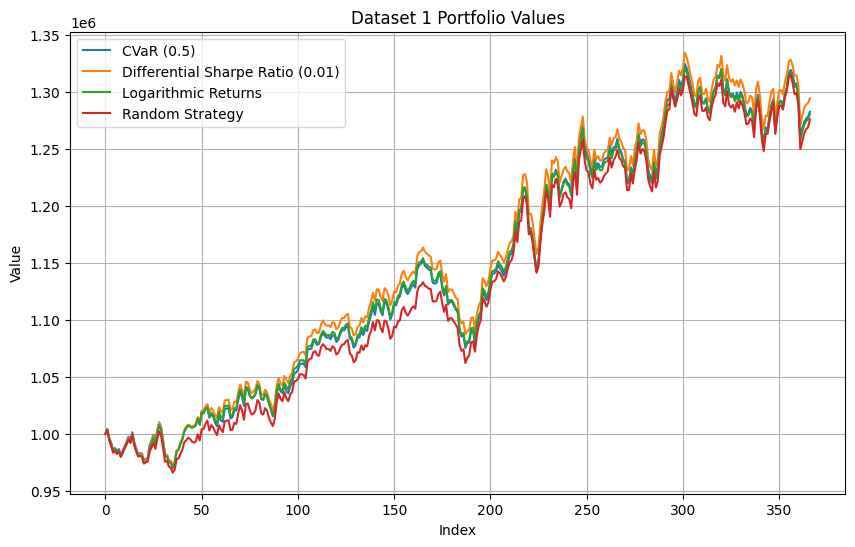

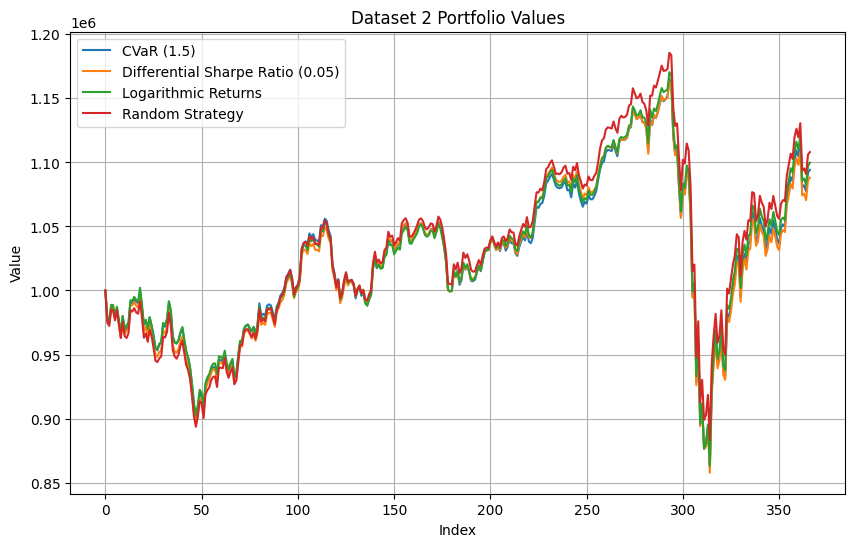

In [28]:
import os
import matplotlib.pyplot as plt

pathToFolder = "portfolios/Test-REWARD FUNCTIONThirdLast/2025-04-16/"

experiment1Files = {
    "Experiment_1_Reward Function-CVaR_0.5 .txt": "CVaR (0.5)",
    "Experiment_1_Reward Function-Differential Sharpe Ratio_0.01 .txt": "Differential Sharpe Ratio (0.01)",
    "Experiment_1_Reward Function-Standard Logarithmic Returns .txt": "Logarithmic Returns",
    "Experiment_1_Strategy-RANDOM .txt": "Random Strategy"
}

experiment2Files = {
    "Experiment_2_Reward Function-CVaR_1.5 .txt": "CVaR (1.5)",
    "Experiment_2_Reward Function-Differential Sharpe Ratio_0.05 .txt": "Differential Sharpe Ratio (0.05)",
    "Experiment_2_Reward Function-Standard Logarithmic Returns .txt": "Logarithmic Returns",
    "Experiment_2_Strategy-RANDOM .txt": "Random Strategy"
}

def readValues(filePath):
    with open(filePath, 'r') as file:
        return [float(line.strip()) for line in file]

def plotExperiment(fileDict, experimentNumber, path):
    plt.figure(figsize=(10, 6))
    for fileName, label in fileDict.items():
        filePath = os.path.join(path, fileName)
        values = readValues(filePath)
        plt.plot(values, label=label)
    plt.title(f"Dataset {experimentNumber} Portfolio Values")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

plotExperiment(experiment1Files, 1, pathToFolder)
plotExperiment(experiment2Files, 2, pathToFolder)